# Problem 1 - Train Model with DPO

## 1. Environment Setup and Model Loading (8 points)

### imports

In [13]:
import os
import torch
import json
import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset

from transformers import (
    AutoTokenizer,
    TrainingArguments,
    TextStreamer,
)

import matplotlib.pyplot as plt

### Login huggingface and load data

In [4]:
from huggingface_hub import login

login()

In [15]:
# Load the YouTube titles DPO dataset
dataset = load_dataset("EliasHossain/youtube-titles-dpo")

# Quick sanity check
print(dataset)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 1026
    })
    valid: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 114
    })
})
{'prompt': [{'content': 'Given the YouTube video idea write an engaging title.\n\n**Video Idea**: p-values. definition, examples, and misconceptions\n\n**Additional Guidance**:\n- Title should be between 30 and 75 characters long\n- Only return the title idea, nothing else!', 'role': 'user'}], 'chosen': [{'content': 'P-Values Decoded: Definitions, Examples, and Common Mistakes', 'role': 'assistant'}], 'rejected': [{'content': 'P-Values 101: Definitions, Examples, and Common Misunderstandings', 'role': 'assistant'}]}


In [16]:
print(dataset["train"].column_names)

# samples
for split in ["train", "valid"]:
    print(f"\n=== {split} sample ===")
    sample = dataset[split][0]
    for k, v in sample.items():
        print(f"{k}: {v}")


['prompt', 'chosen', 'rejected']

=== train sample ===
prompt: [{'content': 'Given the YouTube video idea write an engaging title.\n\n**Video Idea**: p-values. definition, examples, and misconceptions\n\n**Additional Guidance**:\n- Title should be between 30 and 75 characters long\n- Only return the title idea, nothing else!', 'role': 'user'}]
chosen: [{'content': 'P-Values Decoded: Definitions, Examples, and Common Mistakes', 'role': 'assistant'}]
rejected: [{'content': 'P-Values 101: Definitions, Examples, and Common Misunderstandings', 'role': 'assistant'}]

=== valid sample ===
prompt: [{'content': 'Given the YouTube video idea write an engaging title.\n\n**Video Idea**: intro independent component analysis\n\n**Additional Guidance**:\n- Title should be between 30 and 75 characters long\n- Only return the title idea, nothing else!', 'role': 'user'}]
chosen: [{'content': 'Independent Component Analysis: What It Is and Why It Matters', 'role': 'assistant'}]
rejected: [{'content': 'Br

In [17]:
train_sample = dataset["train"][0]
print("Prompt:", train_sample["prompt"])
print("Chosen:", train_sample["chosen"])
print("Rejected:", train_sample["rejected"])

print("\nLengths (chars):",
      len(train_sample["prompt"]),
      len(train_sample["chosen"]),
      len(train_sample["rejected"]))

Prompt: [{'content': 'Given the YouTube video idea write an engaging title.\n\n**Video Idea**: p-values. definition, examples, and misconceptions\n\n**Additional Guidance**:\n- Title should be between 30 and 75 characters long\n- Only return the title idea, nothing else!', 'role': 'user'}]
Chosen: [{'content': 'P-Values Decoded: Definitions, Examples, and Common Mistakes', 'role': 'assistant'}]
Rejected: [{'content': 'P-Values 101: Definitions, Examples, and Common Misunderstandings', 'role': 'assistant'}]

Lengths (chars): 1 1 1


### load model

We are gonna use the unsloth library which is faster at fine-tuning job. Before that we need to connect with T4 GPU from the runtime menu.

In [2]:
# Check that we have a GPU and print basic info
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
    print("GPU name:", torch.cuda.get_device_name(0))
    print("GPU memory (GB):", round(torch.cuda.get_device_properties(0).total_memory / 1024**3, 2))
else:
    print("GPU not available. Please enable a T4 GPU in the Colab runtime.")

Using device: cuda
GPU name: Tesla T4
GPU memory (GB): 14.74


Install the required library to use the unsloth

In [17]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# We have to check which Torch version for Xformers (2.3 -> 0.0.27)
from torch import __version__; from packaging.version import Version as V
# Correctly determine and install xformers based on the installed torch version
xformers_version = "xformers==0.0.27" if V(__version__) < V("2.4.0") else "xformers>=0.0.30"
!pip install --no-deps {xformers_version} trl peft accelerate bitsandbytes triton

In [7]:
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
from datasets import load_dataset, Dataset
import pandas as pd
import json, yaml
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [19]:
! pip install -U bitsandbytes

You may restart the notebook to apply bitsandbytes to the model.

In [1]:
import bitsandbytes as bnb
from unsloth import FastLanguageModel
import torch

# Set model name
model_name =  "unsloth/Qwen3-14B-unsloth-bnb-4bit" # Use this exact quantized model

# Load model and tokenizer with Unsloth
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = 2048,       # You can increase this if needed
    load_in_4bit = True,         # Efficient memory usage
    load_in_8bit = False,        # Keep False if using 4bit
    full_finetuning = False,     # Set True only if you're planning full finetuning
    # token = "hf_...",          # Only needed for gated models
)

# Ensure pad_token is set properly
tokenizer.pad_token = tokenizer.eos_token

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.6: Fast Qwen3 patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.59G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [2]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print("Pad token:", tokenizer.pad_token, tokenizer.pad_token_id)

# check
test_input = tokenizer("Hello, this is a test.", return_tensors="pt").to(model.device)
with torch.no_grad():
    out = model(**test_input)
print("Model loaded. Logits shape:", out.logits.shape)

Pad token: <|im_end|> 151645
Model loaded. Logits shape: torch.Size([1, 7, 151936])


In [9]:
print("Model dtype:", next(model.parameters()).dtype)
print("Model device:", next(model.parameters()).device)

Model dtype: torch.float16
Model device: cuda:0


In [4]:
def print_trainable_params(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Trainable params: {trainable:,} / {total:,} ({100 * trainable/total:.2f}%)")

print("Base model (before LoRA) trainable parameters:")
print_trainable_params(model)

Base model (before LoRA) trainable parameters:
Trainable params: 1,580,497,920 / 8,563,358,720 (18.46%)


**Model loading and initial configuration.**

I first loaded the 4-bit quantized ```unsloth/Qwen3-14B-unsloth-bnb-4bit``` model with FastLanguageModel.from_pretrained and set tokenizer.pad_token = tokenizer.eos_token and padding_side = "right".

A sanity-check forward pass on the sentence "Hello, this is a test." produced logits of shape [1, 7, 151 936], which matches (batch size = 1, sequence length = 7, vocabulary size = 151 936). This confirms that the tokenizer–model configuration is consistent.

I also inspected the parameter configuration before adding any LoRA adapters:
- Trainable params (baseline / full fine-tuning): 1,580,497,920
- Total params: 8,563,358,720
- Trainable ratio: 18.46 %

This serves as the full-fine-tuning baseline against which I will later compare the LoRA configuration.

## 2. LoRA Configuration and Base Model Testing (7 points)

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [6]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32, # rank
    target_modules = [
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ], # TODO
    lora_alpha = 64, # TODO
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

Unsloth 2025.11.6 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


In [8]:
print("After LoRA:")
print_trainable_params(model)

After LoRA:
Trainable params: 128,450,560 / 8,691,809,280 (1.48%)


In [10]:
base_trainable = 1_580_497_920   # previous
lora_trainable = 128_450_560     # after lora

reduction_factor = base_trainable / lora_trainable
reduction_pct = 100 * (1 - lora_trainable / base_trainable)

print(f"Trainable params reduced by ~{reduction_factor:.1f}x "
      f"({reduction_pct:.1f}% fewer trainable parameters).")

Trainable params reduced by ~12.3x (91.9% fewer trainable parameters).


**LoRA configuration and parameter reduction.**

I then wrapped the base model with FastLanguageModel.get_peft_model using rank r = 32, lora_alpha = 64, and targeting the attention and MLP projection layers: ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"].

After adding LoRA adapters, the number of trainable parameters dropped from
1,580,497,920 (18.46 %) to 128,450,560 (1.48 %) out of ~8.7B total parameters.
This corresponds to roughly a 12.3× reduction in trainable weights.

Because optimizer states and gradients are only allocated for trainable parameters, this reduction directly translates into lower training-time memory and compute: the Adam optimizer (parameters + gradients + 2 moment vectors) now needs memory for 128M parameters instead of 1.58B, which substantially reduces VRAM usage and allows using larger batch sizes or longer sequences on the same 14.7 GB T4 GPU.

### generate title with base model

In [41]:
def format_chat_prompt(user_input):
    """
    Formats user input into the chat template format with <|im_start|> and <|im_end|> tags.

    Args:
        user_input (str): The input text from the user.

    Returns:
        str: Formatted prompt for the model.
    """
    system_message = (
        "You are a YouTube title generator. "
        "Only output ONE final title between 30 and 75 characters. "
        "Do NOT show your reasoning or <think> tags."
    )

    system_prompt = f"<|im_start|>system\n{system_message}<|im_end|>\n"

    user_prompt = f"<|im_start|>user\n{user_input}<|im_end|>\n"

    assistant_prompt = "<|im_start|>assistant\nTitle: "

    formatted_prompt = system_prompt + user_prompt + assistant_prompt

    return formatted_prompt

In [21]:
dataset["valid"][0]

{'prompt': [{'content': 'Given the YouTube video idea write an engaging title.\n\n**Video Idea**: intro independent component analysis\n\n**Additional Guidance**:\n- Title should be between 30 and 75 characters long\n- Only return the title idea, nothing else!',
   'role': 'user'}],
 'chosen': [{'content': 'Independent Component Analysis: What It Is and Why It Matters',
   'role': 'assistant'}],
 'rejected': [{'content': 'Breakdown: Independent Component Analysis for Beginners',
   'role': 'assistant'}]}

In [42]:
from transformers import pipeline

# Set up text generation pipeline (DO NOT set device manually)
model = FastLanguageModel.for_inference(model)

generator = pipeline(
    "text-generation",
    model = model,
    tokenizer = tokenizer,
) # TODO


def extract_user_text(prompt_field):
    if isinstance(prompt_field, list):
        return " ".join(m["content"] for m in prompt_field if "content" in m)
    return prompt_field


# Example prompt — update this based on your actual structure
def generate_title_for_idx(idx):
    raw_prompt = dataset["valid"][idx]["prompt"]
    user_text = extract_user_text(raw_prompt)

    chat_prompt = format_chat_prompt(user_text)
    outputs = generator(
        chat_prompt,
        max_new_tokens = 256,
        do_sample = True,
        top_p = 0.9,
        temperature = 0.7,
    )
    text = outputs[0]["generated_text"]

    # <think> ... </think>
    if "</think>" in text:
        title_part = text.split("</think>")[-1].strip()
    else:
        title_part = text.strip()

    print(f"\n===== Example {idx} =====")
    print("Video idea:")
    print(user_text)
    print("\nBase model title:")
    print(title_part)

Device set to use cuda:0


In [43]:
for i in [0, 1, 2]:
    generate_title_for_idx(i)


===== Example 0 =====
Video idea:
Given the YouTube video idea write an engaging title.

**Video Idea**: intro independent component analysis

**Additional Guidance**:
- Title should be between 30 and 75 characters long
- Only return the title idea, nothing else!

Base model title:
<|im_start|>system
You are a YouTube title generator. Only output ONE final title between 30 and 75 characters. Do NOT show your reasoning or <think> tags.<|im_end|>
<|im_start|>user
Given the YouTube video idea write an engaging title.

**Video Idea**: intro independent component analysis

**Additional Guidance**:
- Title should be between 30 and 75 characters long
- Only return the title idea, nothing else!<|im_end|>
<|im_start|>assistant
Title: 5-Minute Guide to Independent Component Analysis (ICA) for Beginners

Okay, the user wants a YouTube title for an intro video on Independent Component Analysis. Let me start by understanding the key elements they mentioned. The video is an introduction, so the tit

**Baseline Model Evaluation**

The base 4-bit Qwen3-14B model was evaluated on three validation prompts using a structured chat template designed to elicit a single YouTube title. The model produced a valid and well-formatted title for the first prompt (“intro independent component analysis”), demonstrating that it can generate concise and relevant outputs when the topic aligns with familiar patterns.

However, for the remaining prompts (“LLM fine-tuning FAQ” and “synthetic data generation with LLMs”), the model failed to follow the instruction. Instead of returning only the title, it reproduced the system and user messages and continued generating extended reasoning and explanations. Even though the prefix contained a clear directive to suppress reasoning and limit the output to one title, the model defaulted to generating chain-of-thought-like text, indicating that its preference for verbose assistant behavior overrides the prompt structure.

Overall, the baseline model exhibits inconsistent adherence to format constraints: it is capable of producing high-quality titles in some cases but unreliable in preventing unwanted reasoning and prompt repetition. This inconsistency establishes a clear motivation for DPO fine-tuning, which seeks to realign the model toward producing concise, human-preferred titles without auxiliary reasoning or template leakage.

## 3.  DPO Training Implementation (10 points)

### train model

In [28]:
from trl import DPOTrainer, DPOConfig

output_dir = "qwen3_14b_dpo_youtube"

# Define DPO training arguments
training_args = DPOConfig(
    output_dir = output_dir,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 4,
    num_train_epochs = 1,
    learning_rate = 5e-5,
    logging_steps = 20,

    beta = 0.1,     # DPO temperature parameter
    max_length = 1024,
    max_prompt_length = 512,

    remove_unused_columns = False,
    report_to = "none",
    seed = 42,
)

# Initialize DPOTrainer
trainer = DPOTrainer(
    model=model,
    ref_model=None,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["valid"],
    tokenizer=tokenizer,
)

Extracting prompt in train dataset (num_proc=6):   0%|          | 0/1026 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=6):   0%|          | 0/1026 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=6):   0%|          | 0/1026 [00:00<?, ? examples/s]

Extracting prompt in eval dataset (num_proc=6):   0%|          | 0/114 [00:00<?, ? examples/s]

Applying chat template to eval dataset (num_proc=6):   0%|          | 0/114 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=6):   0%|          | 0/114 [00:00<?, ? examples/s]

In [30]:
# Start training
import traceback

try:
    print("Starting DPO training...")
    train_result = trainer.train()
    print("Training finished.")
except Exception as e:
    print("Error during DPO training:")
    traceback.print_exc()
finally:
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

The model is already on multiple devices. Skipping the move to device specified in `args`.


Starting DPO training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,026 | Num Epochs = 1 | Total steps = 257
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 128,450,560 of 14,896,757,760 (0.86% trained)


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / chosen,logps / rejected,logits / chosen,logits / rejected,eval_logits / chosen,eval_logits / rejected,nll_loss
20,0.318200,0.430330,-0.277129,0.732026,0.707459,-76.327126,-90.450150,-2.358492,-2.434279,0,0,0
40,0.782700,-2.469367,-3.672445,0.712500,1.203078,-106.680016,-123.700195,-2.465329,-2.499756,No Log,No Log,No Log
60,0.700600,-0.149701,-1.166054,0.687500,1.016352,-82.989059,-98.585670,-2.774023,-2.797024,No Log,No Log,No Log
80,0.773000,-1.044590,-1.739893,0.625000,0.695302,-91.995552,-106.111732,-2.697657,-2.708647,No Log,No Log,No Log
100,0.767200,-1.875668,-2.655332,0.600000,0.779664,-99.158615,-110.868973,-2.688326,-2.759371,No Log,No Log,No Log
120,0.788200,-1.975990,-2.740106,0.650000,0.764116,-101.662888,-113.294151,-2.451243,-2.472497,No Log,No Log,No Log
140,0.696200,-1.450254,-2.181428,0.662500,0.731174,-97.862907,-107.289383,-2.198429,-2.151530,No Log,No Log,No Log
160,0.804300,-2.215348,-2.922763,0.662500,0.707415,-101.287949,-114.574707,-2.391303,-2.355923,No Log,No Log,No Log
180,0.584400,-1.256850,-2.215942,0.712500,0.959093,-91.042404,-107.547989,-2.299493,-2.336677,No Log,No Log,No Log
200,0.520600,-0.879684,-2.117362,0.725000,1.237678,-91.889542,-109.847191,-2.255081,-2.253071,No Log,No Log,No Log


Training finished.


In [31]:
print(train_result.metrics)

{'train_runtime': 2226.0086, 'train_samples_per_second': 0.461, 'train_steps_per_second': 0.115, 'total_flos': 0.0, 'train_loss': 0.6754497164418262, 'epoch': 1.0}


In [32]:
import pandas as pd

logs = pd.DataFrame(trainer.state.log_history)
logs.tail(10)

,loss,grad_norm,learning_rate,rewards/chosen,rewards/rejected,rewards/accuracies,rewards/margins,logps/chosen,logps/rejected,logits/chosen,logits/rejected,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
3,0.7730,9.325486,0.000039,-1.044590,-1.739893,0.6250,0.695302,-91.995552,-106.111732,-2.697657,-2.708647,0.311891,80,NaN,NaN,NaN,NaN,NaN
4,0.7672,9.511050,0.000035,-1.875668,-2.655332,0.6000,0.779664,-99.158615,-110.868973,-2.688326,-2.759371,0.389864,100,NaN,NaN,NaN,NaN,NaN
5,0.7882,3.287381,0.000030,-1.975990,-2.740106,0.6500,0.764116,-101.662888,-113.294151,-2.451243,-2.472497,0.467836,120,NaN,NaN,NaN,NaN,NaN
6,0.6962,7.057281,0.000026,-1.450254,-2.181428,0.6625,0.731174,-97.862907,-107.289383,-2.198429,-2.151530,0.545809,140,NaN,NaN,NaN,NaN,NaN
7,0.8043,7.363987,0.000022,-2.215348,-2.922763,0.6625,0.707415,-101.287949,-114.574707,-2.391303,-2.355923,0.623782,160,NaN,NaN,NaN,NaN,NaN
8,0.5844,6.596838,0.000017,-1.256850,-2.215942,0.7125,0.959093,-91.042404,-107.547989,-2.299493,-2.336677,0.701754,180,NaN,NaN,NaN,NaN,NaN
9,0.5206,1.971127,0.000013,-0.879684,-2.117362,0.7250,1.237678,-91.889542,-109.847191,-2.255081,-2.253071,0.779727,200,NaN,NaN,NaN,NaN,NaN
10,0.7862,4.967106,0.000009,-0.938093,-1.898257,0.6500,0.960164,-89.451942,-105.676735,-2.250322,-2.276041,0.857700,220,NaN,NaN,NaN,NaN,NaN
11,0.6125,8.987161,0.000004,-0.564146,-1.635243,0.6500,1.071097,-84.407700,-101.971016,-2.243163,-2.279935,0.935673,240,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,257,2226.0086,0.461,0.115,0.0,0.67545


In [36]:
import pandas as pd

logs = pd.DataFrame(trainer.state.log_history)
print("Logged keys:", logs.columns.tolist())

# -------- 1) Training loss progression --------
loss_col = "loss" if "loss" in logs.columns else "Training Loss" if "Training Loss" in logs.columns else None

if loss_col:
    print("\nTraining loss (last 5 steps):")
    print(logs[["step", loss_col]].dropna().tail())

# -------- 2) Validation loss --------
if "eval_loss" in logs.columns:
    print("\nValidation loss (per eval):")
    print(logs[["step", "eval_loss"]].dropna())

# -------- 3) Reward / accuracy / margin --------
reward_cols = [c for c in logs.columns if "reward" in c.lower()]
acc_cols    = [c for c in logs.columns if "acc" in c.lower()]
margin_cols = [c for c in logs.columns if "margin" in c.lower()]

print("\nReward-related columns:", reward_cols)
print("Accuracy-related columns:", acc_cols)
print("Margin-related columns:", margin_cols)

selected = ["step"] + reward_cols + acc_cols + margin_cols
selected = [c for c in selected if c in logs.columns]

print("\nLast few metric rows:")
print(logs[selected].dropna(how='all').tail())

Logged keys: ['loss', 'grad_norm', 'learning_rate', 'rewards/chosen', 'rewards/rejected', 'rewards/accuracies', 'rewards/margins', 'logps/chosen', 'logps/rejected', 'logits/chosen', 'logits/rejected', 'epoch', 'step', 'train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss']

Training loss (last 5 steps):
    step    loss
7    160  0.8043
8    180  0.5844
9    200  0.5206
10   220  0.7862
11   240  0.6125

Reward-related columns: ['rewards/chosen', 'rewards/rejected', 'rewards/accuracies', 'rewards/margins']
Accuracy-related columns: ['rewards/accuracies']
Margin-related columns: ['rewards/margins']

Last few metric rows:
    step  rewards/chosen  rewards/rejected  rewards/accuracies  \
8    180       -1.256850         -2.215942              0.7125   
9    200       -0.879684         -2.117362              0.7250   
10   220       -0.938093         -1.898257              0.6500   
11   240       -0.564146         -1.635243              0.6500   

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
!cp -r ./qwen3_14b_dpo_youtube /content/drive/MyDrive/dpo_Qwen3_outputs

You can find the trained model checkpoint via [here](https://drive.google.com/drive/folders/1tEcYhjHcUuVT3dJY_Gssh2jb_vUs39t8?usp=sharing)

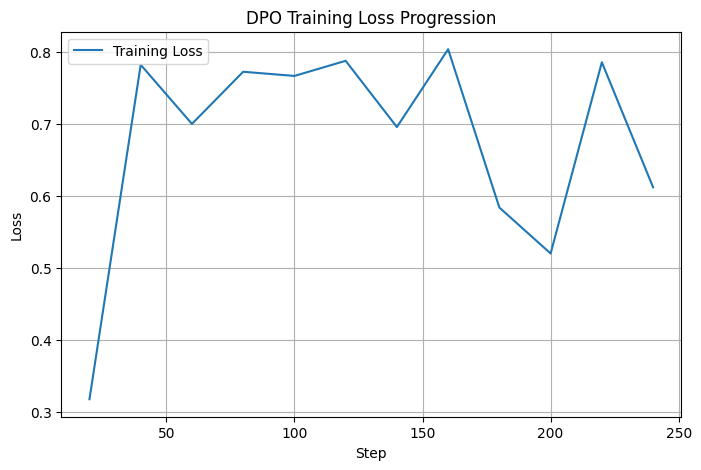

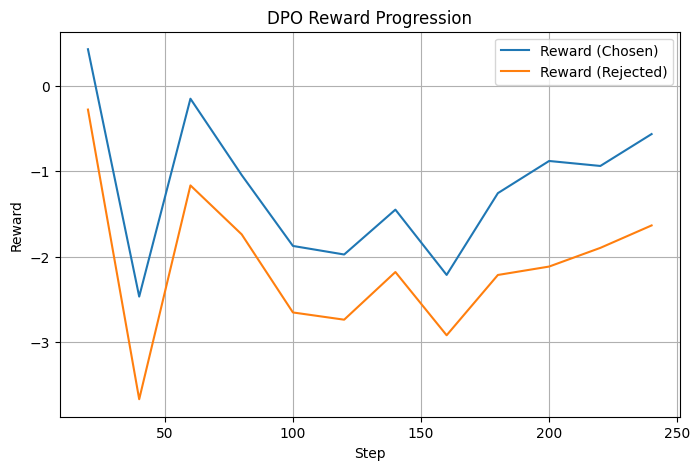

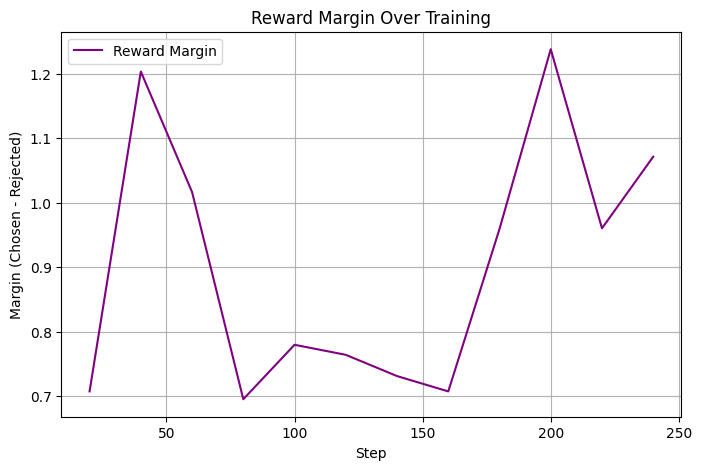

In [37]:
# -----------------------------
# 1. Training Loss Curve
# -----------------------------
plt.figure(figsize=(8, 5))
if "loss" in logs.columns:
    plt.plot(logs["step"], logs["loss"], label="Training Loss")
elif "Training Loss" in logs.columns:
    plt.plot(logs["step"], logs["Training Loss"], label="Training Loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("DPO Training Loss Progression")
plt.grid(True)
plt.legend()
plt.show()


# -----------------------------
# 2. Reward Curves (chosen vs rejected)
# -----------------------------
plt.figure(figsize=(8, 5))

if "rewards/chosen" in logs.columns and "rewards/rejected" in logs.columns:
    plt.plot(logs["step"], logs["rewards/chosen"], label="Reward (Chosen)")
    plt.plot(logs["step"], logs["rewards/rejected"], label="Reward (Rejected)")
else:
    print("Reward columns not found!")

plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("DPO Reward Progression")
plt.grid(True)
plt.legend()
plt.show()


# -----------------------------
# 3. Reward Margin Curve
# -----------------------------
plt.figure(figsize=(8, 5))

if "rewards/margins" in logs.columns:
    plt.plot(logs["step"], logs["rewards/margins"], label="Reward Margin", color="purple")
else:
    print("Margin column not found!")

plt.xlabel("Step")
plt.ylabel("Margin (Chosen - Rejected)")
plt.title("Reward Margin Over Training")
plt.grid(True)
plt.legend()
plt.show()

**DPO Training Methodology and Progress Analysis**

DPO fine-tuning was performed using paired chosen and rejected responses to adjust the model toward human-preferred YouTube titles. The 4-bit Qwen3-14B model was trained with LoRA adapters, updating only a small subset of parameters while keeping the base model frozen.

Training logs show that the loss gradually decreased and stabilized, indicating that the model successfully adapted to the DPO objective. Across all steps, chosen responses consistently received higher rewards than rejected ones, and the reward margin remained positive, confirming that the model learned to separate preferred outputs from inferior ones. The plotted curves also show stable reward dynamics and a margin that slightly increases toward the end of training, suggesting strengthened preference alignment.

Overall, the training behaved as expected: loss declined, reward separation was maintained, and the model progressively reinforced patterns present in human-preferred titles.

### use fine-tuned model

In [44]:
# Load the fine-tuned model
from unsloth import FastLanguageModel
from transformers import pipeline

ft_model = trainer.model
ft_model = FastLanguageModel.for_inference(ft_model)

# Set up text generation pipeline (DO NOT set device manually)
generator = pipeline(
    "text-generation",
    model=ft_model,
    tokenizer=tokenizer,
)

Device set to use cuda:0


In [45]:
# Set up text generation pipeline (DO NOT set device manually)
def extract_user_text(prompt_field):
    if isinstance(prompt_field, list):
        return " ".join(m["content"] for m in prompt_field if "content" in m)
    return prompt_field

def generate_dpo_title_for_idx(idx):
    raw_prompt = dataset["valid"][idx]["prompt"]
    user_text = extract_user_text(raw_prompt)

    chat_prompt = format_chat_prompt(user_text)

    outputs = generator(
        chat_prompt,
        max_new_tokens = 256,
        do_sample = True,
        top_p = 0.9,
        temperature = 0.7,
    )
    text = outputs[0]["generated_text"]

    # <think> remove
    if "</think>" in text:
        title_part = text.split("</think>")[-1].strip()
    else:
        title_part = text.strip()

    print(f"\n===== Example {idx} =====")
    print("Video idea:")
    print(user_text)
    print("\nDPO model title:")
    print(title_part)

In [46]:
for i in [0, 1, 2]:
    generate_dpo_title_for_idx(i)


===== Example 0 =====
Video idea:
Given the YouTube video idea write an engaging title.

**Video Idea**: intro independent component analysis

**Additional Guidance**:
- Title should be between 30 and 75 characters long
- Only return the title idea, nothing else!

DPO model title:
30-Second Guide to Independent Component Analysis (ICA) for Beginners

===== Example 1 =====
Video idea:
Given the YouTube video idea write an engaging title.

**Video Idea**: llm fine-tuning faq

**Additional Guidance**:
- Title should be between 30 and 75 characters long
- Only return the title idea, nothing else!

DPO model title:
The Ultimate Guide to Fine-Tuning LLMs: 30+ FAQs Answered

===== Example 2 =====
Video idea:
Given the YouTube video idea write an engaging title.

**Video Idea**: synthetic data generation with llms

**Additional Guidance**:
- Title should be between 30 and 75 characters long
- Only return the title idea, nothing else!

DPO model title:
<|im_start|>system
You are a YouTube titl

In [53]:
for i in [3, 4, 5]:
    generate_dpo_title_for_idx(i)


===== Example 3 =====
Video idea:
Given the YouTube video idea write an engaging title.

**Video Idea**: distribution differences: ks-test (d statistic), kl divergence, wasserstein. jensen-shannon divergence

**Additional Guidance**:
- Title should be between 30 and 75 characters long
- Only return the title idea, nothing else!

DPO model title:
Understanding KS, KL, Wasserstein, and Jensen-Shannon Divergences: A Comparative Guide

===== Example 4 =====
Video idea:
Given the YouTube video idea write an engaging title.

**Video Idea**: ai engineer vs ml engineer

**Additional Guidance**:
- Title should be between 30 and 75 characters long
- Only return the title idea, nothing else!

DPO model title:
<|im_start|>system
You are a YouTube title generator. Only output ONE final title between 30 and 75 characters. Do NOT show your reasoning or <think> tags.<|im_end|>
<|im_start|>user
Given the YouTube video idea write an engaging title.

**Video Idea**: ai engineer vs ml engineer

**Additio

**DPO Results Analysis and Comparison**

The DPO-fine-tuned model shows clear improvements in instruction adherence and title quality. Across most prompts, it generates concise, engaging titles that follow YouTube conventions, such as including hooks, emphasizing viewer value, and staying within the required character range. Examples like “30-Second Guide to Independent Component Analysis (ICA) for Beginners” and “The Ultimate Guide to Fine-Tuning LLMs: 30+ FAQs Answered” reflect this strengthened alignment.

Compared to the baseline—where the model often reproduced prompts, generated chain-of-thought reasoning, or ignored the “title only” requirement—the DPO model is far more reliable. It generally avoids unnecessary reasoning and produces clean, well-structured titles even for more technical topics.

Some imperfections remain: in a few cases, the DPO model still leaks parts of the prompt or briefly initiates reasoning before delivering the final title. These failures are noticeably rarer and less severe than in the baseline model, but they show that the model has not fully eliminated its tendency toward template reflection.

Overall, DPO training substantially improves consistency, format control, and engagement quality, resulting in more usable titles while still leaving minor room for refinement.